In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.signal import welch, get_window
import os


from funcs_dsp import *
from funcs_df import load_df

In [71]:
# Load dataframe(s) and concatenate (with laptop=False and no dfs_to_load this loads all dataframes with OSC paths)
laptop = True
dfs_to_load = ["UWO Data"]
df_UWO = load_df(laptop=laptop, dfs_to_load=dfs_to_load)

Loading UWO Data


OSError: [Errno 22] Invalid argument

In [6]:
# Restrict to just waveform rows
df = df[df['wf'].notna()]

In [69]:
# Get frequency axis
f = rfftfreq(32768, 1/44100)

index = 10
wf = df.iloc[index]['wf']
sr = 44100

padding = 4

# chris_welch = get_welch_og_chris(wf)
f, my_welch_hann = get_welch(wf, win_type='hann', n_win=32768)
f, my_welch_boxcar = get_welch(wf, win_type='boxcar', n_win=32768)
chris_welch = get_welch_og_chris(wf)
f_padded, my_welch_hann_padded = get_welch(wf, win_type='hann', n_win=32768, zero_pad=padding)
f_padded, my_welch_boxcar_padded = get_welch(wf, win_type='boxcar', n_win=32768, zero_pad=padding)

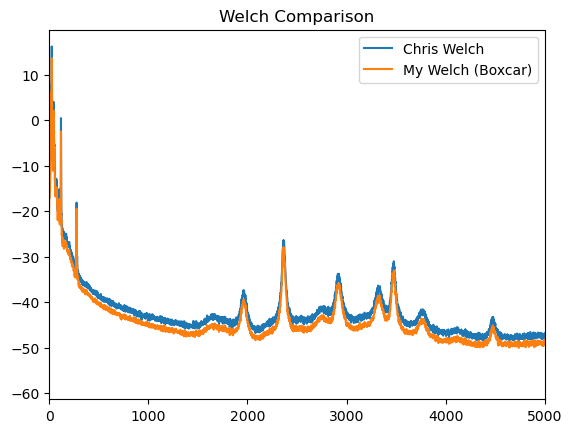

In [70]:
plt.plot(f, chris_welch, label='Chris Welch')
# plt.plot(f, my_welch_hann, label=f'My Welch (Hann)', alpha=1)
plt.plot(f, my_welch_boxcar, label=f'My Welch (Boxcar)', alpha=1)
# plt.plot(f_padded, my_welch_hann_padded, label=f'My Welch Padded (Hann)', alpha=1)
# splt.plot(f_padded, my_welch_boxcar_padded, label=f'My Welch Padded (Boxcar)', alpha=1)


plt.xlim(0, 5000)
# plt.ylim(7.5, 15)
plt.title(f"Welch Comparison")
plt.legend()
plt.show()

In [105]:
# Get frequency axis
f = rfftfreq(32768, 1/44100)

index = 10
wf = df.iloc[index]['wf']
sr = 44100

win_type='hann'
padding = 16

# chris_welch = get_welch_og_chris(wf)
f, my_welch = get_welch(wf, win_type='hann', n_win=32768)
f_higher_res_padded, my_welch_higher_res_padded = get_welch(wf, win_type=win_type, n_win=262144, zero_pad=padding)
f_higher_res, my_welch_higher_res = get_welch(wf, win_type=win_type, n_win=262144)
f_highest_res, my_welch_highest_res = get_welch(wf, win_type=win_type, n_win=524288)
# pg = get_pg(wf, win_type=win_type)
# pg_halved = get_pg(wf[0:len(wf)//2], win_type=win_type)

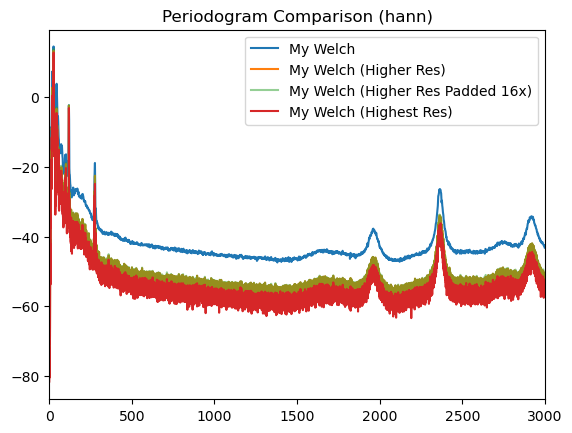

In [106]:
# plt.plot(f, chris_welch, label='Chris Welch')
plt.plot(f, my_welch, label=f'My Welch', alpha=1)
plt.plot(f_higher_res, my_welch_higher_res, label=f'My Welch (Higher Res)', alpha=1)
plt.plot(f_higher_res_padded, my_welch_higher_res_padded, label=f'My Welch (Higher Res Padded {padding}x)', alpha=0.5)
plt.plot(f_highest_res, my_welch_highest_res, label=f'My Welch (Highest Res)')
# plt.plot(rfftfreq(len(wf), 1/sr), pg, label='Periodogram')
# plt.plot(rfftfreq(len(wf)//2, 1/sr), pg_halved, label='Periodogram (Halved)', alpha=0.5)

plt.xlim(0, 3000)
# plt.ylim(7.5, 15)
plt.title(f"Periodogram Comparison ({win_type})")
plt.legend()
plt.show()


# f_scipy, scipy_welch = get_scipy_welch(wf, win_type=win_type, n_win=32768)
# plt.plot(f_scipy, scipy_welch, label='Scipy Welch', alpha=0.5)
# print(my_welch)
# print(scipy_welch)

In [36]:
# "Exploring noise and signal addition"

# # Parameters
# fs = 1000  # Sampling frequency (Hz)
# duration = 100  # Duration of the signal (seconds)
# n_samples = fs * duration  # Total number of samples
# f_sine = 100  # Frequency of the sine wave (Hz)
# noise_amp = 500
# more_noise_amp = 2000
# sine_amp = 100
# window = 'hann'

# # Generate white noise
# base_noise = np.random.normal(0, 1, n_samples)
# white_noise = noise_amp * base_noise
# more_white_noise = more_noise_amp * base_noise

# # Generate a sine wave at 100 Hz
# t = np.arange(n_samples) / fs  # Time vector
# sine_wave = sine_amp * np.sin(2 * np.pi * f_sine * t)

# # Add the sine wave to the white noise
# signal_with_sine = white_noise + sine_wave
# more_white_noise_with_sine = more_white_noise + sine_wave

# # Compute the Power Spectral Density (PSD) of the white noise
# f_white_noise, Pxx_white_noise = welch(white_noise, fs, window=window, nperseg=4096)

# # Compute the Power Spectral Density (PSD) of the more white noise
# f_more_white_noise, Pxx_more_white_noise = welch(more_white_noise, fs, window=window, nperseg=4096)

# # Compute the Power Spectral Density (PSD) of the signal with the sine wave
# f_signal, Pxx_signal = welch(signal_with_sine, fs, window=window, nperseg=4096)

# # Compute the Power Spectral Density (PSD) of the signal with the sine wave
# f_signal_more_noise, Pxx_signal_more_noise = welch(more_white_noise_with_sine, fs, window=window, nperseg=4096)

# # Compute the Power Spectral Density (PSD) of the sine wave
# f_sine_wave, Pxx_sine_wave = welch(sine_wave, fs, window=window, nperseg=4096)

# # Plot both power spectra (White Noise and White Noise + Sine Wave) on the same plot
# plt.figure(figsize=(10, 6))

# plt.plot(f_white_noise, Pxx_white_noise, label='White Noise', color='b')
# plt.plot(f_more_white_noise, Pxx_more_white_noise, label='More White Noise', color='purple')
# plt.plot(f_signal_more_noise, Pxx_signal_more_noise, label='More White Noise + Sine Wave (100 Hz)', color='g', linestyle='--')
# plt.plot(f_signal, Pxx_signal, label='White Noise + Sine Wave (100 Hz)', color='r', linestyle='--')

# plt.title('Power Spectrum of White Noise and White Noise + Sine Wave and More White Noise + Sine Wave')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density (W/Hz)')
# plt.xlim(90, 110)
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

# # # Plot the power spectrum of just the sine wave
# # plt.figure(figsize=(10, 6))
# # plt.plot(f_sine_wave, Pxx_sine_wave, label='Sine Wave at 100 Hz', color='g')
# # plt.title('Power Spectrum of Sine Wave at 100 Hz')
# # plt.xlabel('Frequency (Hz)')
# # plt.ylabel('Power Spectral Density (W/Hz)')
# # plt.xlim(90, 110)
# # plt.legend()
# # plt.grid()

# # plt.tight_layout()
# # plt.show()

# # Find the index closest to 100 Hz in the frequency arrays
# index_100Hz_signal = np.argmin(np.abs(f_signal - f_sine))
# index_100Hz_white_noise = np.argmin(np.abs(f_white_noise - f_sine))
# index_100Hz_sine_wave = np.argmin(np.abs(f_sine_wave - f_sine))

# # Get the power spectral densities at 100 Hz for both signals
# Pxx_white_noise_100Hz = Pxx_white_noise[index_100Hz_white_noise]
# Pxx_signal_100Hz = Pxx_signal[index_100Hz_signal]
# Pxx_sine_wave_100Hz = Pxx_sine_wave[index_100Hz_sine_wave]

# # Compute the difference between the two spectra at 100 Hz
# difference_at_100Hz = Pxx_signal_100Hz - Pxx_white_noise_100Hz

# # Print the power at {f_sine} Hz for each spectrum and the difference
# print(f"Power Spectrum at {f_sine} Hz for White Noise: {Pxx_white_noise_100Hz:.6f} W/Hz")
# print(f"Power Spectrum at {f_sine} Hz for White Noise + Sine Wave: {Pxx_signal_100Hz:.6f} W/Hz")
# print(f"Power Spectrum at {f_sine} Hz for Sine Wave: {Pxx_sine_wave_100Hz:.6f} W/Hz")
# print(f"Difference in Power Spectrum at 100 Hz (White Noise + Sine Wave - White Noise): {difference_at_100Hz:.6f} W/Hz")

In [63]:
def my_welch(wf, fs):
    # Define window length
    n_win = 512
    n_padded = int(n_win*64)
    n_shift = int(n_win*0.5)
    num_wins=None

    
    n_possible_win_starts = len(wf) - n_win # Number of samples that could be a start of a sample
    n_full_wins_from_possible_win_starts = np.floor(n_possible_win_starts / n_shift) # Number of full windows we can get out of this set
    max_num_wins = n_full_wins_from_possible_win_starts + 1 # Add one more because the final sample in n_possible_win_starts can always be a sample (though the real start will likely be before this)
    num_wins_final = int(min(num_wins, max_num_wins)) if num_wins is not None else int(max_num_wins) # Use num_wins if provided and valid, otherwise use the maximum number of windows we can get
    
    window = get_window('hann', n_win)
    norm = 2*np.ones((n_padded // 2) + 1) # Multiply by two for real FFT (only using half the frequencies)
    norm[0] = 1  # ...except for the DC and
    norm[-1] = 1 # Nyquist frequencies
    norm /= np.sum(window)**2 # Squared sum of window coefficients for window normalization (just N for rectangle)
    
    # Divide the waveform into windows of length n_win, take magnitude of FFT of each
    powers_list = [
        norm*np.abs(rfft(np.pad(wf[i*n_shift : i*n_shift + n_win]*window, (0, n_padded-n_win), 'constant')))**2 # Each new window has a start index that's n_shift more than the last
        for i in range(num_wins_final)
    ]

    # Average over all windows
    return rfftfreq(n_padded, 1/fs), np.mean(powers_list, axis=0)

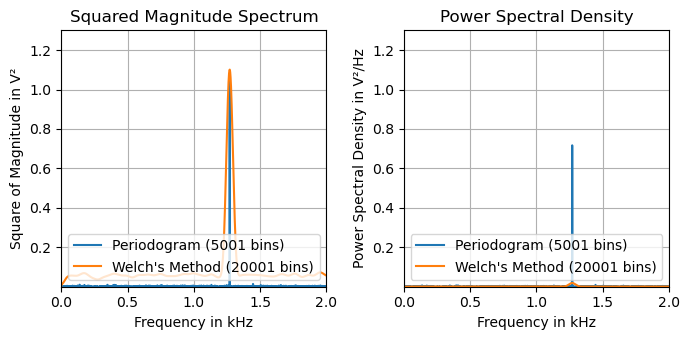

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 2, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx[0].set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
for ax_, s_ in zip(axx, ('spectrum', 'density')):
    f_p, P_p = signal.periodogram(x, fs, 'hann', scaling=s_)
    f_w, P_w = signal.welch(x, fs, scaling=s_, nfft=int(len(x)*4))
    # f_w, P_w = my_welch(x, fs)
    
    # ax_.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    # ax_.semilogy(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    ax_.plot(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    ax_.plot(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    
    ax_.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
    ax_.grid(True)
    ax_.legend(loc='lower center')
plt.show()

Max value in P_w: 0.8202835908652172
Index of max value in P_w: 33
Max value in P_w_unscaled: 6719.763176367859
Index of max value in P_w_unscaled: 33
Max value in P_w_sp: 0.8202835908652173
Index of max value in P_w_sp: 33


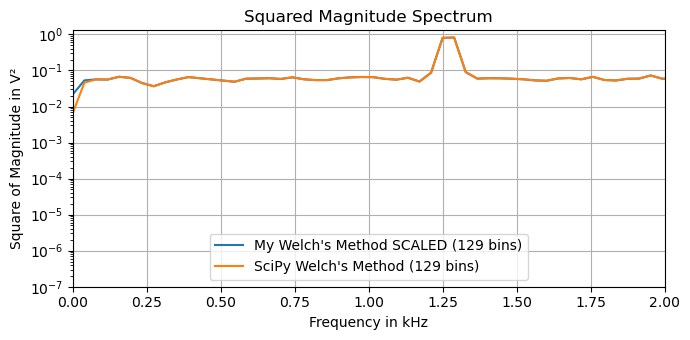

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

n_padded = 256

def my_welch(wf, fs, scale=True):
    # Define window length
    n_win = 256
    n_shift = int(n_win*0.5)
    num_wins = None

    
    n_possible_win_starts = len(wf) - n_win # Number of samples that could be a start of a sample
    n_full_wins_from_possible_win_starts = np.floor(n_possible_win_starts / n_shift) # Number of full windows we can get out of this set
    max_num_wins = n_full_wins_from_possible_win_starts + 1 # Add one more because the final sample in n_possible_win_starts can always be a sample (though the real start will likely be before this)
    num_wins_final = int(min(num_wins, max_num_wins)) if num_wins is not None else int(max_num_wins) # Use num_wins if provided and valid, otherwise use the maximum number of windows we can get
    
    window = get_window('hann', n_win)
    norm = 2*np.ones((n_padded // 2) + 1) # Multiply by two for real FFT (only using half the frequencies)
    norm[0] = 1  # ...except for the DC and
    norm[-1] = 1 # ...Nyquist frequencies
    norm /= np.sum(window)**2 # Squared sum of window coefficients for window normalization (just N for rectangle)
    
    if scale==False:
        norm = 1
    
    # Divide the waveform into windows of length n_win, take magnitude of FFT of each
    powers_list = [
        norm*np.abs(rfft(np.pad(wf[i*n_shift : i*n_shift + n_win]*window, (0, n_padded-n_win), 'constant')))**2 # Each new window has a start index that's n_shift more than the last
        for i in range(num_wins_final)
    ]

    # Average over all windows
    return rfftfreq(n_padded, 1/fs), np.mean(powers_list, axis=0)
    # return rfftfreq(n_padded, 1/fs), powers_list[0]

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 1, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx.set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
# axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
f_p, P_p = signal.periodogram(x, fs, 'hann', scaling='spectrum')
f_w_sp, P_w_sp = signal.welch(x, fs, 'hann', scaling='spectrum')
f_w, P_w = my_welch(x, fs)
f_w_unscaled, P_w_unscaled = my_welch(x, fs, scale=False)
# axx.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
axx.semilogy(f_w/1e3, P_w, label=f"My Welch's Method SCALED ({len(f_w)} bins)")
# axx.semilogy(f_w_unscaled/1e3, P_w_unscaled, label=f"My Welch's Method UNSCALED ({len(f_w)} bins)")
axx.semilogy(f_w_sp/1e3, P_w_sp, label=f"SciPy Welch's Method ({len(f_w_sp)} bins)")
axx.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
axx.grid(True)
axx.legend(loc='lower center')

print("Max value in P_w:", np.max(P_w))
print("Index of max value in P_w:", np.argmax(P_w))

print("Max value in P_w_unscaled:", np.max(P_w_unscaled))
print("Index of max value in P_w_unscaled:", np.argmax(P_w_unscaled))

print("Max value in P_w_sp:", np.max(P_w_sp))
print("Index of max value in P_w_sp:", np.argmax(P_w_sp))


plt.show()

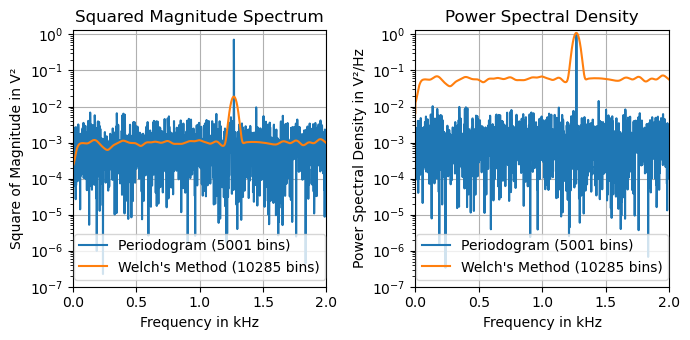

Max value in P_w: 1.1008583774157477
Index of max value in P_w: 2612


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 2, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx[0].set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
for ax_, s_ in zip(axx, ('density', 'spectrum')):
    f_p, P_p = signal.periodogram(x, fs, 'hann', scaling=s_)
    f_w, P_w = signal.welch(x, fs, scaling=s_, nfft=n_padded)
    ax_.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    ax_.semilogy(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    ax_.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
    ax_.grid(True)
    ax_.legend(loc='lower center')
plt.show()

print("Max value in P_w:", np.max(P_w))
print("Index of max value in P_w:", np.argmax(P_w))



PERIODOGRAM
Total power from PSD: 5000.0000 (linear)
Total power from Power Spectrum: 7500.0000 (linear)
WELCH
Total power from PSD: 4999.9999 (linear)
Total power from Power Spectrum: 7499.9998 (linear)
Average power of the signal in the time domain: 5000.0000 (linear)


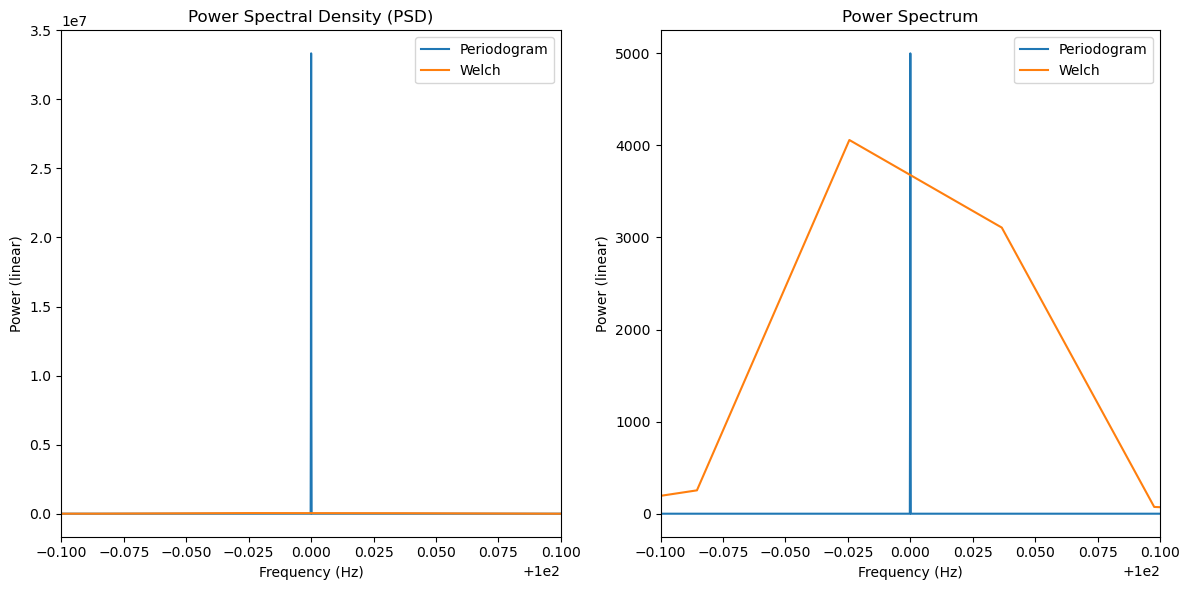

In [184]:
"Exploring PS vs PSD with/without Welch, with/without noise"
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, periodogram

# Parameters
fs = 1000  # Sampling frequency in Hz
t_max = 10000 # Signal duration in seconds
freq = 100  # Frequency of the sinusoid in Hz
decay_rate = 0 # Exponential decay rate
n_samples = fs * t_max  # Number of samples
n_win = 2**14
window_type = 'hann'
A = 100 # Amplitude of the decaying sinusoid
t = np.linspace(0, t_max, n_samples, endpoint=False)  # Time vector

# Generate exponentially decaying sinusoid
signal = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t)

# Calculate Power Spectral Density (PSD) using Welch's method
f_psd, P_psd = periodogram(signal, fs, window=window_type, scaling='density')

# Calculate Power Spectrum (squared magnitude of FFT)
f_ps, ps = periodogram(signal, fs, window=window_type, scaling='spectrum')

# Calculate Power Spectral Density (PSD) using Welch's method
f_psd_welch, P_psd_welch = welch(signal, fs, nperseg=n_win, window=window_type, scaling='density')

# Calculate Power Spectrum (squared magnitude of FFT)
f_ps_welch, ps_welch = welch(signal, fs, nperseg=n_win, window=window_type, scaling='spectrum')

# Frequency bin width (delta f) for PSD
delta_f = f_psd[1] - f_psd[0]
delta_f_welch = f_psd_welch[1] - f_psd_welch[0]

# # Generate the window using scipy's get_window function
# window = get_window(window_type, n_win)

# # Calculate the sum of squared window coefficients
# sum_squared_window = np.sum(window**2)

# # Calculate the square of the sum of window coefficients
# square_of_sum_window = np.sum(window)**2

# Find indices for the frequency range 50-150 Hz
freq_min = 99  # Minimum frequency in Hz
freq_max = 101  # Maximum frequency in Hz

# Find indices where the frequencies are between 50 and 150 Hz
ps_welch_indices = np.where((f_ps_welch >= freq_min) & (f_ps_welch <= freq_max))
psd_welch_indices = np.where((f_psd_welch >= freq_min) & (f_psd_welch <= freq_max))
ps_indices = np.where((f_ps >= freq_min) & (f_ps <= freq_max))
psd_indices = np.where((f_psd >= freq_min) & (f_psd <= freq_max))

# Total power from PSD (sum over all bins, multiplying by delta f)
total_power_psd = np.sum(P_psd[psd_indices] * delta_f)
total_power_welch_psd = np.sum(P_psd_welch[psd_welch_indices] * delta_f_welch)

# Total power from Power Spectrum (sum over all bins)
total_power_spectrum = np.sum(ps[ps_indices])
total_power_welch_spectrum = np.sum(ps_welch[ps_welch_indices])

# Print total power in allcases
print("PERIODOGRAM")
print(f"Total power from PSD: {total_power_psd:.4f} (linear)")
print(f"Total power from Power Spectrum: {total_power_spectrum:.4f} (linear)")
print("WELCH")
print(f"Total power from PSD: {total_power_welch_psd:.4f} (linear)")
print(f"Total power from Power Spectrum: {total_power_welch_spectrum:.4f} (linear)")


# Calculate average power in the time domain
average_power_time_domain = np.mean(signal**2)

# Print the result
print(f"Average power of the signal in the time domain: {average_power_time_domain:.4f} (linear)")

# Plot results
plt.figure(figsize=(12, 6))

# Plot PSD (linear scale)
plt.subplot(1, 2, 1)
plt.plot(f_psd, P_psd, label='Periodogram')
plt.plot(f_psd_welch, P_psd_welch, label='Welch')
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (linear)')
plt.xlim(99.9, 100.1)
plt.legend()

# Plot Power Spectrum (linear scale)
plt.subplot(1, 2, 2)
plt.plot(f_ps, ps, label='Periodogram')
plt.plot(f_ps_welch, ps_welch, label='Welch')
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (linear)')
plt.xlim(99.9, 100.1)
plt.legend()

plt.tight_layout()
plt.show()
